In [88]:
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from jaxtyping import Float
import pandas as pd
import equinox as eqx
import matplotlib.pyplot as plt


@dataclass
class StockOptionData:
    """Dataclass containing the relevant information regarding the stock and option prices."""

    expiration_date: np.datetime64
    strike_price: float
    datestamps: np.ndarray
    stock_prices: np.ndarray
    price_ratios: np.ndarray
    call_prices: np.ndarray

    def num_business_days(self):
        return np.busday_count(self.datestamps[0], self.expiration_date)


def make_stockoption_data(
    stock_csv: Path,
    option_csv: Path,
    expiration_date: datetime | str,
    strike_price: float,
) -> StockOptionData:
    read_csv = partial(
        pd.read_csv, delimiter=",", parse_dates=[0], encoding="ascii", header=None
    )
    df_stock, df_option = read_csv(stock_csv), read_csv(option_csv)

    # Extract relevant information from the stock price csv
    stock_price, price_ratio = tuple(
        df_stock.iloc[::-1, idx].to_numpy() for idx in (1, 3)
    )
    option_price = df_option.iloc[::-1, -4].to_numpy()
    date_stock = df_stock.iloc[::-1, 0].values.astype(
        "datetime64[D]"
    )  # Hack to get the dates datetime64[D] type instead of the default datetime64[ns]
    # date_option = df_option.iloc[:,0].values.astype('datetime64[D]')
    # assert np.all(date_stock==date_option) is True, "The timestamps for the stock and option csvs do not match!"
    date_expir = (
        pd.to_datetime(expiration_date, format=r"%Y/%m/%d")
        .to_numpy()
        .astype("datetime64[D]")
    )
    return StockOptionData(
        date_expir, strike_price, date_stock, stock_price, price_ratio, option_price
    )


data = make_stockoption_data(
    "samsung_stock.csv", "samsung_2409_6e4.csv", "2024/09/12", 6e4
)


187

# 1. Visualize the stock and option prices over time

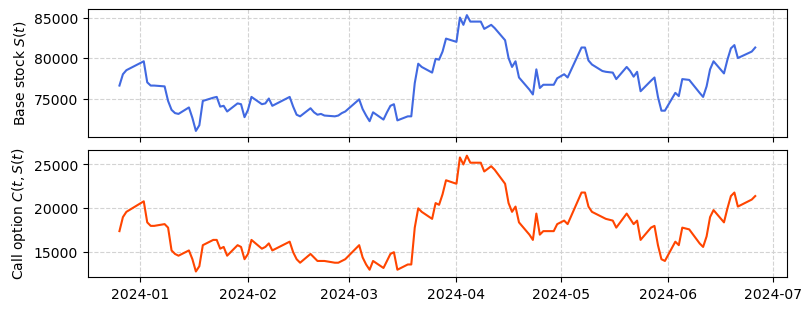

In [95]:
fig, axes = plt.subplots(2, 1, figsize = (8, 3), sharex = True, constrained_layout = True)
axes[0].plot(data.datestamps, data.stock_prices, color = "royalblue")
axes[0].set_ylabel("Base stock $S(t)$")
axes[1].plot(data.datestamps, data.call_prices, color = "orangered")
axes[1].set_ylabel("Call option $C(t, S(t)$")
for ax in axes:
    ax.grid(ls = "--", color = "lightgray")

# Black-Scholes equation

\begin{equation}
\frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} -rC = 0
\end{equation}

Subject to the boundary conditions
\begin{align}
    &C(t, 0) = 0\\
    &C(t, S\rightarrow \infty) \rightarrow S-K\\
    &C(t=T, S) = \max(S-K, 0)
\end{align}

# 2. Normalize the dataset

\begin{equation}
\tilde{C} = C/K,\quad \tilde{S}= S/K
\end{equation}

All time units are in business years and $r$, $\sigma^2$ are in inverse business years (1 byr = 252 days).

The scaled equation becomes:

\begin{equation}
\frac{\partial \tilde{C}}{\partial t} + \frac{1}{2}\sigma^2 \tilde{S}^2 \frac{\partial^2 \tilde{C}}{\partial \tilde{S}^2} + rS\frac{\partial \tilde{C}}{\partial \tilde{S}} -r\tilde{C} = 0
\end{equation}

Subject to the boundary conditions
\begin{align}
    &\tilde{C}(t, 0) = 0\\
    &\tilde{C}(t, \tilde{S}\rightarrow \infty) \rightarrow \tilde{S}-1\\
    &\tilde{C}(t=T, \tilde{S}) = \max(\tilde{S}-1, 0)
\end{align}

In [96]:
class BlackScholes(eqx.Module):
    sigma: float
    r: float
    K: float

    def make_pde_loss(self, C):
        sigma, r = self.sigma, self.r

        def pde_loss(t, S):
            return (
                D_t(C)(t, S)
                + 0.5 * (sigma * S) ** 2 * D_x(D_x(C))(t, S)
                + r * S * D_x(C)(t, S)
                - r * C(t, S)
            )

        return pde_loss

    def make_initval_loss(self, C, T=1.0):
        def initval_loss(S):
            return C(T, S) - jax.nn.relu(S - self.K)

        return initval_loss

    def make_zerobdry_loss(self, C):
        def zerobdry_loss(t):
            return C(t, jnp.asarray(0.0))

        return zerobdry_loss

    def make_inftybdry_loss(self, C, S_infty=50.0):
        def inftybdry_loss(t):
            return C(t, jnp.asarray(S_infty)) - (S_infty - self.K)

        return inftybdry_loss


class NN(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, seed=0):
        rng_key = jax.random.PRNGKey(seed)
        self.net = eqx.nn.MLP(
            in_size=2,
            out_size="scalar",
            width_size=256,
            depth=2,
            activation=jax.nn.gelu,
            key=rng_key,
        )

    def __call__(self, t, S):
        tS = jnp.stack((t, S), axis=-1)
        return self.net(tS)


net = NN()
val = net(jnp.asarray(0.0), jnp.asarray(0.5))


def D_t(f):
    @eqx.filter_grad
    def g(x, y):
        return f(x, y)

    return g


def D_x(f):
    def g(x, y):
        def _f(x_y):
            x, y = x_y
            return f(x, y)

        return eqx.filter_grad(_f)((x, y))[1]

    return g


print(D_t(net)(jnp.asarray(0.0), jnp.asarray(0.5)))
print(
    (
        net(jnp.asarray(0.0 + 1e-3), jnp.asarray(0.5))
        - net(jnp.asarray(0.0 - 1e-3), jnp.asarray(0.5))
    )
    / 2e-3
)

print(D_x(net)(jnp.asarray(0.0), jnp.asarray(0.5)))
print(
    (
        net(jnp.asarray(0.0), jnp.asarray(0.5 + 1e-3))
        - net(jnp.asarray(0.0), jnp.asarray(0.5 - 1e-3))
    )
    / 2e-3
)

-0.009642618
-0.009643844
0.0057369005
0.0057341526


In [3]:
bs = BlackScholes(0.5, 0.01, 10.0)
pde_loss_fn = bs.make_pde_loss(net)
pde_loss_fn(jnp.asarray(0.0), jnp.asarray(0.5))

zerobdry_loss_fn = bs.make_zerobdry_loss(net)
inftybdry_loss_fn = bs.make_inftybdry_loss(net)
initval_loss_fn = bs.make_initval_loss(net)

In [4]:
Nt = 100  # Number of samples
Nx = 100  # Number of samples
t = jnp.linspace(0, 1.0, Nt)  # Input data for t (N x 1)
S = jnp.linspace(0, 50.0, Nx)  # Input data for x (N x 1)
t_grid, S_grid = jnp.meshgrid(t, S)
t_grid.shape

eqx.filter_vmap(zerobdry_loss_fn)(t)

Array([ 3.89739498e-03,  3.78736109e-03,  3.64947692e-03,  3.52728181e-03,
        3.41423415e-03,  3.28711234e-03,  3.16497497e-03,  3.03619727e-03,
        2.91757844e-03,  2.80118361e-03,  2.68485397e-03,  2.57050805e-03,
        2.44885311e-03,  2.33227387e-03,  2.23798305e-03,  2.12051719e-03,
        2.02127919e-03,  1.92549266e-03,  1.80425867e-03,  1.70098431e-03,
        1.60261244e-03,  1.50470063e-03,  1.40536204e-03,  1.31826103e-03,
        1.22429244e-03,  1.12289563e-03,  1.02305785e-03,  9.32995230e-04,
        8.58262181e-04,  7.61583447e-04,  6.82292506e-04,  6.02778047e-04,
        5.16090542e-04,  4.43167984e-04,  3.51261348e-04,  2.81427056e-04,
        2.03827396e-04,  1.22064725e-04,  5.18225133e-05, -1.56778842e-05,
       -8.75182450e-05, -1.38031319e-04, -2.34393403e-04, -2.94473022e-04,
       -3.42540443e-04, -4.20065597e-04, -4.98585403e-04, -5.55612147e-04,
       -5.94547018e-04, -6.60773367e-04, -7.14067370e-04, -7.62984157e-04,
       -8.30624253e-04, -

In [5]:
@eqx.filter_value_and_grad
def compute_loss(net):
    pde_loss_fn = eqx.filter_vmap(bs.make_pde_loss(net))
    zerobdry_loss_fn = eqx.filter_vmap(bs.make_zerobdry_loss(net))
    inftybdry_loss_fn = eqx.filter_vmap(bs.make_inftybdry_loss(net))
    initval_loss_fn = eqx.filter_vmap(bs.make_initval_loss(net))

    return (
        jnp.mean(zerobdry_loss_fn(t) ** 2)
        + jnp.mean(inftybdry_loss_fn(t) ** 2)
        + jnp.mean(initval_loss_fn(S) ** 2)
        + jnp.mean(pde_loss_fn(t_grid.reshape(-1), S_grid.reshape(-1)) ** 2)
    )


compute_loss(net)

(Array(1862.2964, dtype=float32),
 NN(
   net=MLP(
     layers=(
       Linear(
         weight=f32[256,2],
         bias=f32[256],
         in_features=2,
         out_features=256,
         use_bias=True
       ),
       Linear(
         weight=f32[256,256],
         bias=f32[256],
         in_features=256,
         out_features=256,
         use_bias=True
       ),
       Linear(
         weight=f32[1,256],
         bias=f32[1],
         in_features=256,
         out_features='scalar',
         use_bias=True
       )
     ),
     activation=None,
     final_activation=None,
     use_bias=True,
     use_final_bias=True,
     in_size=2,
     out_size='scalar',
     width_size=256,
     depth=2
   )
 ))

In [6]:
import optax

learning_rate = 1e-4
optim = optax.adam(learning_rate)


@eqx.filter_jit
def make_step(model, opt_state):
    loss, grads = compute_loss(model)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


losses = []
n_epochs = 50000
opt_state = optim.init(eqx.filter(net, eqx.is_array))
for epoch in range(n_epochs):
    loss, net, opt_state = make_step(net, opt_state)
    loss = loss.item()
    print(f"epoch={epoch}, loss={loss}")
    losses.append(loss)

epoch=0, loss=1862.29638671875
epoch=1, loss=1761.6263427734375
epoch=2, loss=1664.2066650390625
epoch=3, loss=1570.1939697265625
epoch=4, loss=1479.5009765625
epoch=5, loss=1392.1287841796875
epoch=6, loss=1308.436767578125
epoch=7, loss=1228.381103515625
epoch=8, loss=1151.6588134765625
epoch=9, loss=1078.0906982421875
epoch=10, loss=1007.8719482421875
epoch=11, loss=940.779052734375
epoch=12, loss=876.727783203125
epoch=13, loss=815.8995971679688
epoch=14, loss=758.1491088867188
epoch=15, loss=703.136474609375
epoch=16, loss=650.9887084960938
epoch=17, loss=601.5801391601562
epoch=18, loss=554.920654296875
epoch=19, loss=510.9469909667969
epoch=20, loss=469.6977233886719
epoch=21, loss=431.0694580078125
epoch=22, loss=394.8933410644531
epoch=23, loss=361.1072692871094
epoch=24, loss=329.6250915527344
epoch=25, loss=300.2408752441406
epoch=26, loss=273.12567138671875
epoch=27, loss=248.02320861816406
epoch=28, loss=224.8800811767578
epoch=29, loss=203.52940368652344
epoch=30, loss=18

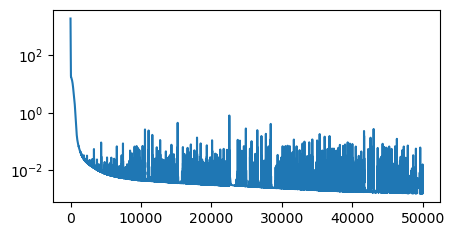

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.plot(losses)
ax.set_yscale("log", base=10)

In [8]:
C_pred = jax.vmap(net)(t_grid.reshape(-1), S_grid.reshape(-1)).reshape(t_grid.shape)
C_pred.shape

(100, 100)

Text(0.5, 0, 'Option price $C(t, S)$')

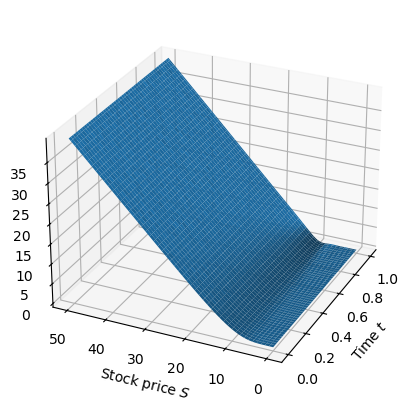

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection="3d"))
ax.plot_surface(t_grid, S_grid, C_pred)
ax.view_init(27, -155)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Stock price $S$")
ax.set_zlabel("Option price $C(t, S)$")